# Group Project Report: Home Price Regression

### <em>Team Members: Adam Neufeld, Camila Fogaca Dall Bello, Jeremy Davies, Max Makovey

## 1. Introduction

#### 1.1 Background Information

Housing prices vary due to a confluence of factors including location, living space, lot size, to name only a few. The extent to which each factor correlates with house prices is not a cut and dry formula. As such, it can be difficult to predict what price one should sell or offer for a house. This project is built to help figure out these values and the variables that affect housing prices.

#### 1.2 Objective Question

Can we predict home prices based on given input real estate factors such as living space size, lot size, and age of the home?

#### 1.3 Dataset Description

The dataset comprises data for ~1500 house sales in the city of Ames, Iowa from 2006-2010. The response variable in this dataset is the sale price of each home. Additionally, there are ~80 descriptive real estate factors (including living area, # of bedrooms, and lot size) for each observation.

<b>Description of variables of interest:</b>
- SalePrice (response variable): The property's sale price in USD. 
- GrLivArea: Above ground living area in square feet. This variable is significant because it directly correlates with the size of the home. On average, we believe larger homes will sell for higher prices. 
- LotArea: Lot size of property in square feet. This variable is significant because irrespective of the home size, we predict that a larger lot size will correlate with greater sale prices.
- YearBuilt: Year of original construction date. This variable is significant because we can use to it measure the age of the home at its sale date. On average, we expect newer homes to be more valuable.

## 2. Methods & Results

#### 2.1 Reading in data

In [27]:
# Necessary libraries to install:
# - 'gsheet', 'tidyverse', 'cowplot' , 'tidymodels', 'repr', 'GGally'
install.packages('gsheet')

# Load in libaries
library(tidyverse)
library(cowplot)
library(tidymodels)
library(gsheet)
library(repr)
library(GGally)

# Suppress table outputs to a manageable # of rows
options(repr.matrix.max.rows = 8)

# Read data from web
data <- gsheet2tbl('docs.google.com/spreadsheets/d/1nNlzfwXkHVk2i946pgf3247KT2vqCDfHZjrBjT-losg/edit?usp=sharing')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



#### 2.2 Clean and wrangle data

In [13]:
# In this cell, we clean and pre-process the data
# Note: original dataset is already tidy (each obs forms a row, each variable a column, each cell a single measurement)

# Rename invalid column header
names(data)[70] <- "ThreeSsnPorch"

# Select only the columns (variables) that we evaluated as meaningfully and potentially significant
data_selected <- data %>%
    select(Id, LotArea,YearBuilt, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, YrSold, SalePrice) %>%
    mutate(NumTotalBaths = BsmtFullBath + FullBath + 0.5*(BsmtHalfBath + HalfBath), AgeWhenSold = YrSold-YearBuilt, SalesPrice=SalePrice) %>%
    select(-BsmtFullBath, -BsmtHalfBath, -FullBath, -HalfBath, -YearBuilt, -YrSold, -SalePrice) %>%
    mutate(SalePrice = SalesPrice) %>%
    select(-SalesPrice)

# Inspect clean dataframe
data_selected

Id,LotArea,GrLivArea,NumTotalBaths,AgeWhenSold,SalePrice
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8450,1710,3.5,5,208500
2,9600,1262,2.5,31,181500
3,11250,1786,3.5,7,223500
4,9550,1717,2.0,91,140000
⋮,⋮,⋮,⋮,⋮,⋮
1457,13175,2073,3.0,32,210000
1458,9042,2340,2.0,69,266500
1459,9717,1078,2.0,60,142125
1460,9937,1256,2.5,43,147500


In [19]:
#In this cell we split data into a training and testing set
set.seed(1234)

data_selected <- as.data.frame(data_selected)

data_split <- initial_split(data_selected, prop = 3/4, strata = NULL)
data_train <- training(data_split)
data_test <- testing(data_split)

# Prepare dfs with only numeric and only non-numeric columns (training dataset ONLY) 
data_train_final <- data_train %>%
    select(-Id)

#### 2.3 Tabular Summary of Data

##### 2.3.1 Summary of numeric variables

In [20]:
# TODO (!!!) Show the number of observations in dataset in a separate table (instead of in cell below)


#insert code here

In [21]:
# Calculate descriptive summary stats by variable (training data only)
data_counts <- colSums(!is.na(data_train_final))
data_unique_counts <- summarize_all(data_train_final,n_distinct,na.rm=TRUE)  
data_max <- summarize_all(data_train_final,max, na.rm = TRUE)  
data_min <- summarize_all(data_train_final,min, na.rm = TRUE)   
data_mean <- summarize_all(data_train_final,mean, na.rm = TRUE)   




# Bind summary stats into one summary table
data_observations <- data_counts %>%
    rbind(data_unique_counts) %>%
    rbind(data_max) %>%
    rbind(data_min) %>%
    rbind(data_mean) %>%
    signif(4)

data_observations <- cbind(ObservationType = c("Valid obs count", "Unique count", "Maximum value","Minimum value", "Mean value"), data_observations)

data_observations

ObservationType,LotArea,GrLivArea,NumTotalBaths,AgeWhenSold,SalePrice
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Valid obs count,1095,1095,1095.000,1095.00,1095
Unique count,831,722,10.000,118.00,547
Maximum value,215200,5642,6.000,136.00,755000
Minimum value,1300,520,1.000,0.00,34900
Mean value,10560,1523,2.213,36.95,181200


#### 2.4 Visual Summary of Data

##### 2.4.1 Scatterplot grid for quick scan of correlations

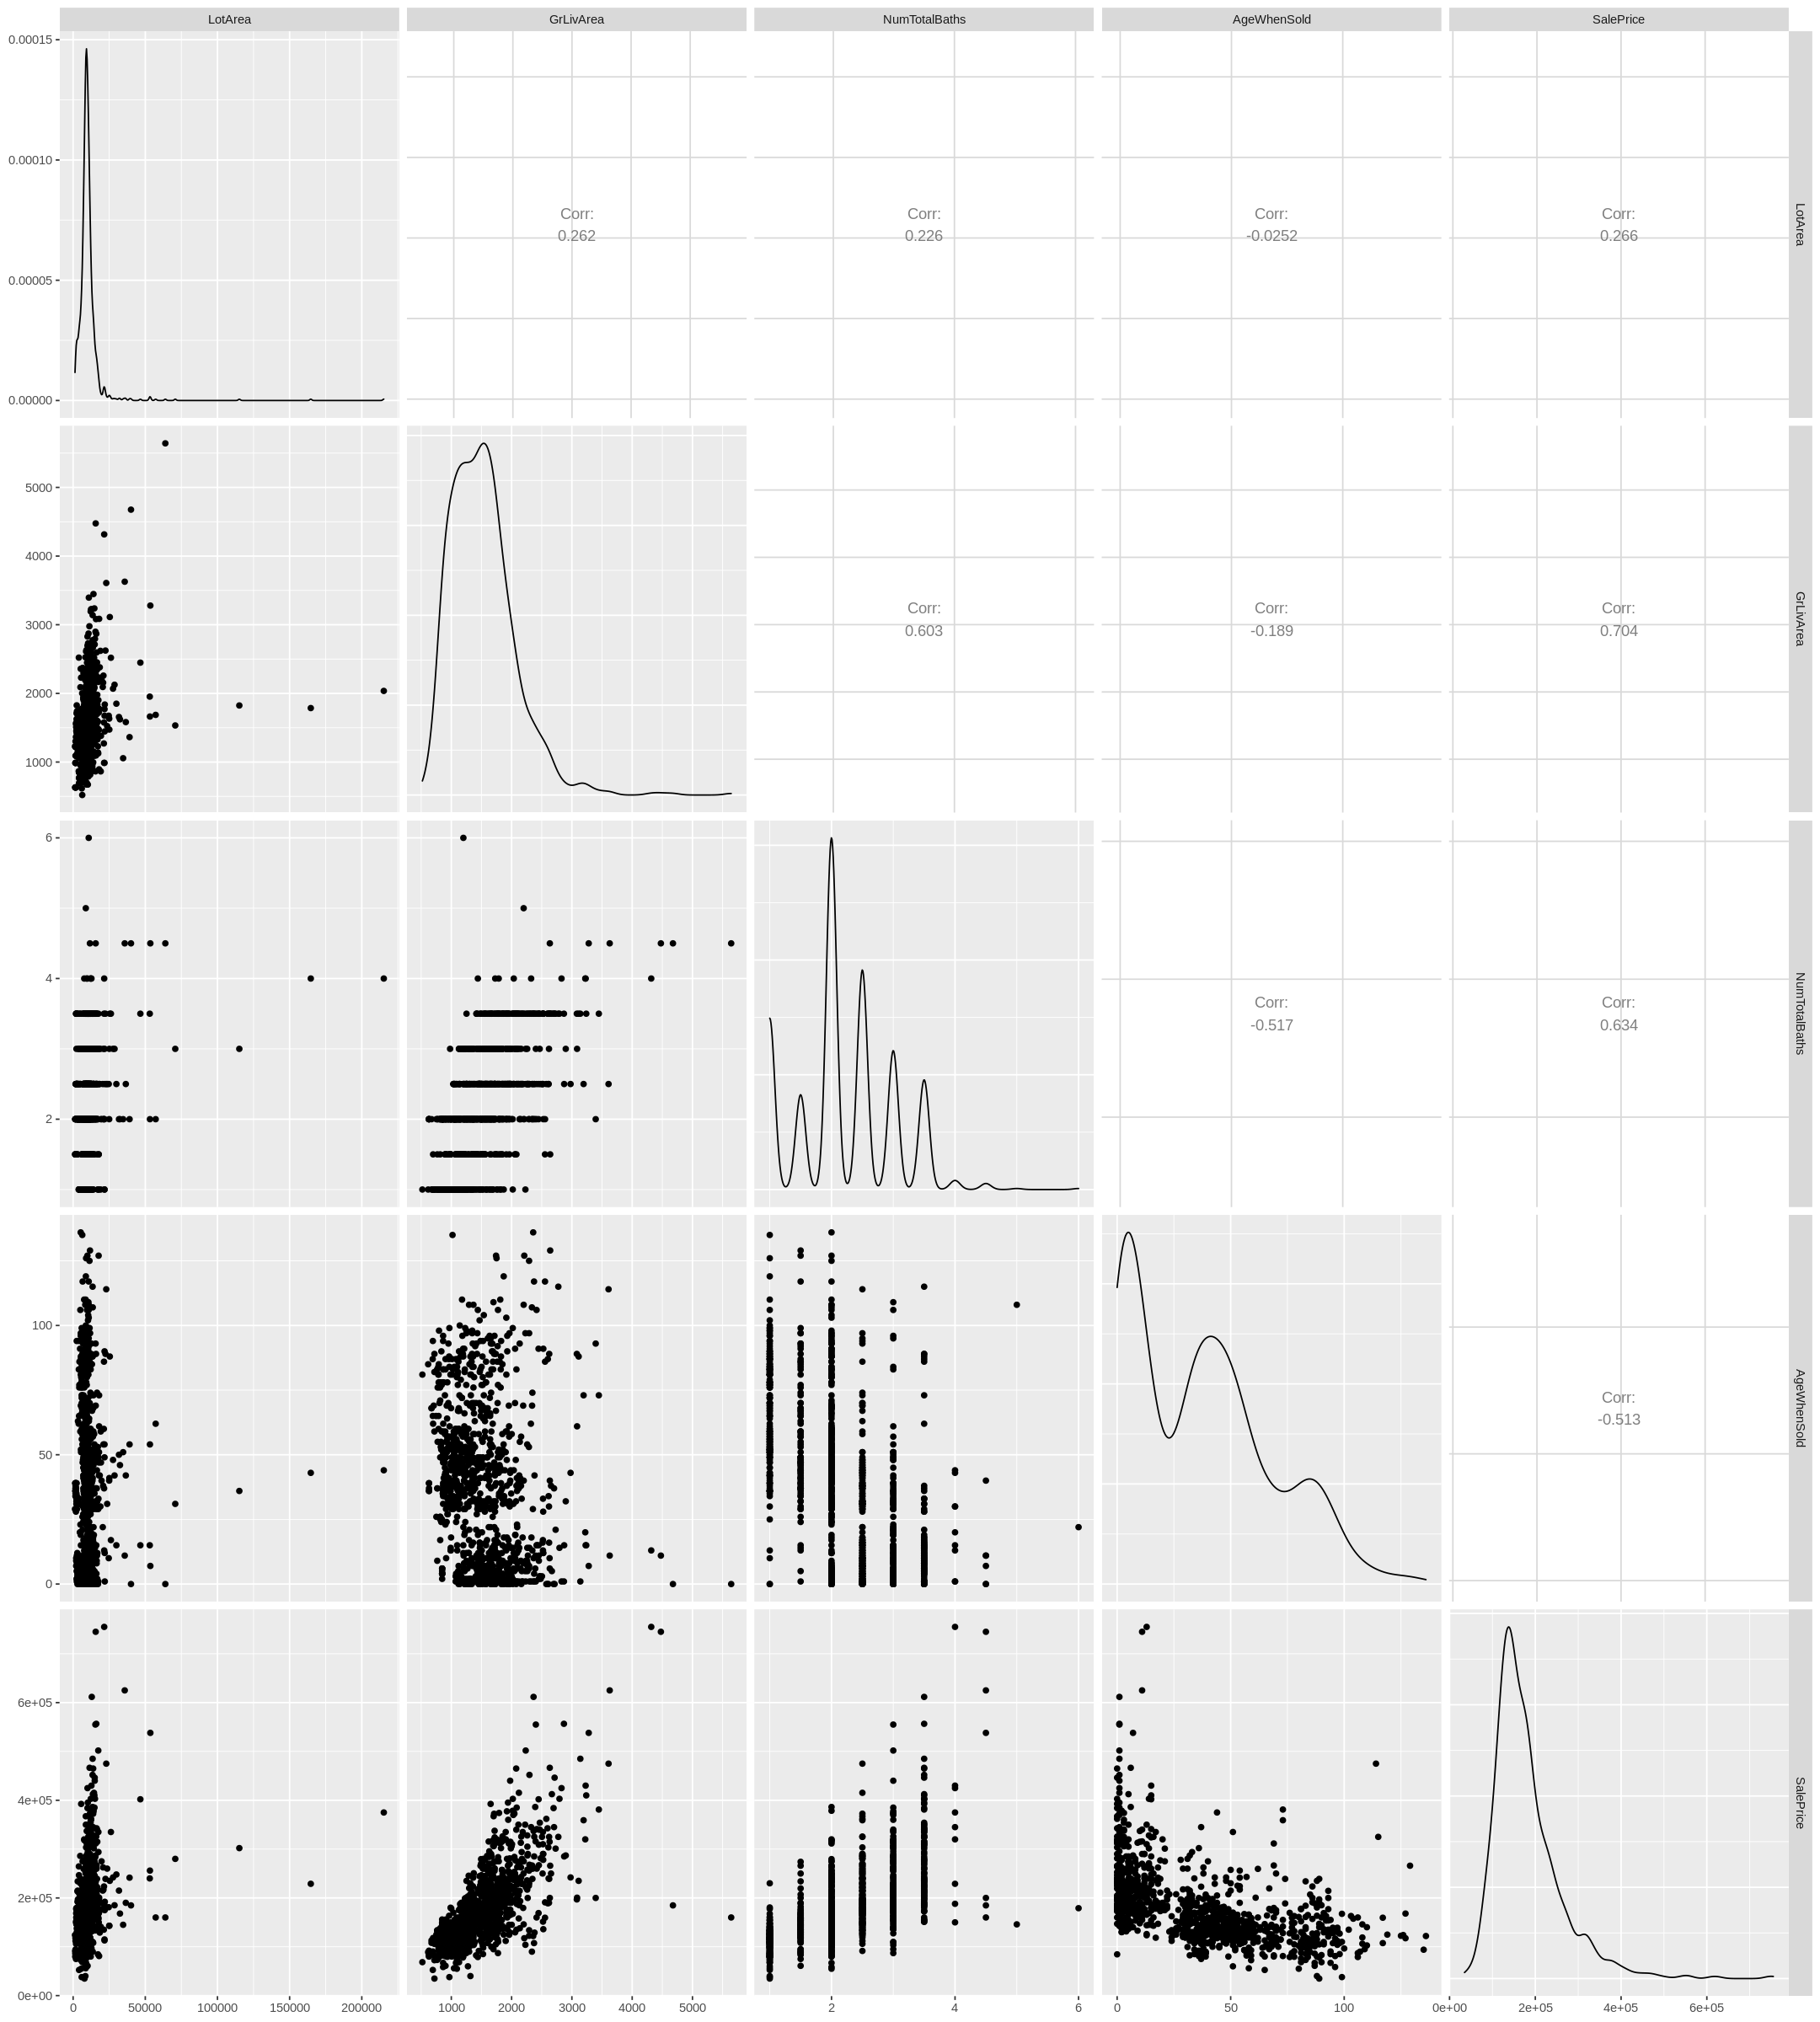

In [28]:
#set plot output size
options(repr.plot.width = 18, repr.plot.height = 20)

ggpairs(data_train_final)

##### 2.4.2 Sale price by living area size and year built

In [18]:
# set plot output size
options(repr.plot.width = 8, repr.plot.height = 8)

# create scatterplot
#exterior_plot<- ggplot( data_train, aes(x=GrLivArea , y=SalePrice, color= YearBuilt) ) + 
#        geom_point(alpha = 0.5) +
#        labs(x = "Above Ground Living Area (sf)", y = "Sale Price ($)", colour = "Year Built") +
#        ggtitle("Sale Price by Living Area and Year Built") +
#        theme(text = element_text(size = 16))
        
#exterior_plot

#### 2.5 Data analysis

##### 2.5.1. Variable selection for the linear regression model

In [8]:
# Start analysis here
#To choose our variables, we aimed to choose the ones with the most influence in price. 
#In order to achieve that, we analyzied different research that focused on determinants of house prices. 
#It was found that locality, living area, lot size and age were the most influential factors
#(Zietz, J et.al, 2018; Aminah Md Yusof, 2012; Johansson, Anna,2017)
#However, due to the complexity of using a categorical variable, in order to perform a linear regression model,
# such as location, and because we would like our model to be visually demonstrating, we opted to su

Despite what literature said, lot size had a very low correlation to sales price, and we decided to remove that. In addition, we noted that the number of bathrooms was highly correlated with the living area, so we removed the number of bathrooms as a predictive variable.

##### 2.5.2 Fit Linear Regression Model

Fit a linear regression model using tidymodels with (Ames) data_train using [THE VARIABLES SELECTED JUST ABOVE]. - We will create a model specification, recipe, and pass that into a workflow, then create the model fit.

In [29]:
# initialize model spec
lm_spec <- linear_reg() %>%
set_engine("lm") %>%
set_mode("regression")

# prepare recipe
homes_recipe <- recipe(SalePrice ~ GrLivArea + AgeWhenSold, data = data_train_final)

# construct workflow
homes_fit <- workflow() %>%
add_recipe(homes_recipe) %>%
add_model(lm_spec) %>%
fit(data = data_train_final)

homes_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    GrLivArea  AgeWhenSold  
   75833.22        94.37     -1036.62  


(!!! TODO) write down equation for linear model and explain interpretation in English (e.g. holding all other variables constant, a 1 unit increase in ...)

##### 2.5.!!! Evaluation of linear regression model

To evaluate how our model might do at predicting on unseen data, we are calculating its Root Mean Squared Prediction Error (RMSPE) on the test data. RMSPE effectively measures how closely our model predicts values of the sale price relative to the actual sale prices of the observations. If our model is a good predictor, we want to see a smaller RMSPE.

In [44]:
# Compute RMSPE  (!!! TODO)
homes_rmspe <- homes_fit %>%
predict(data_test) %>%
bind_cols(data_test) %>%
metrics(truth = SalePrice, estimate = .pred) %>%
filter(.metric == "rmse") %>%
pull(.estimate) %>%
signif(5)

cat("Root Mean Squared Prediction Error: ", homes_rmspe)

Root Mean Squared Prediction Error:  42783

!!! (TODO). Discuss RMSPE result in one sentence or two.

Result is a little high. Compared to the mean home sale price of 181,000 dollars our predictions are off by about 20% on average. $(42000/181000  = 0.2)$

#### 2.6 Visualization of the analysis

!!! (TODO) Quick intro to the visualization

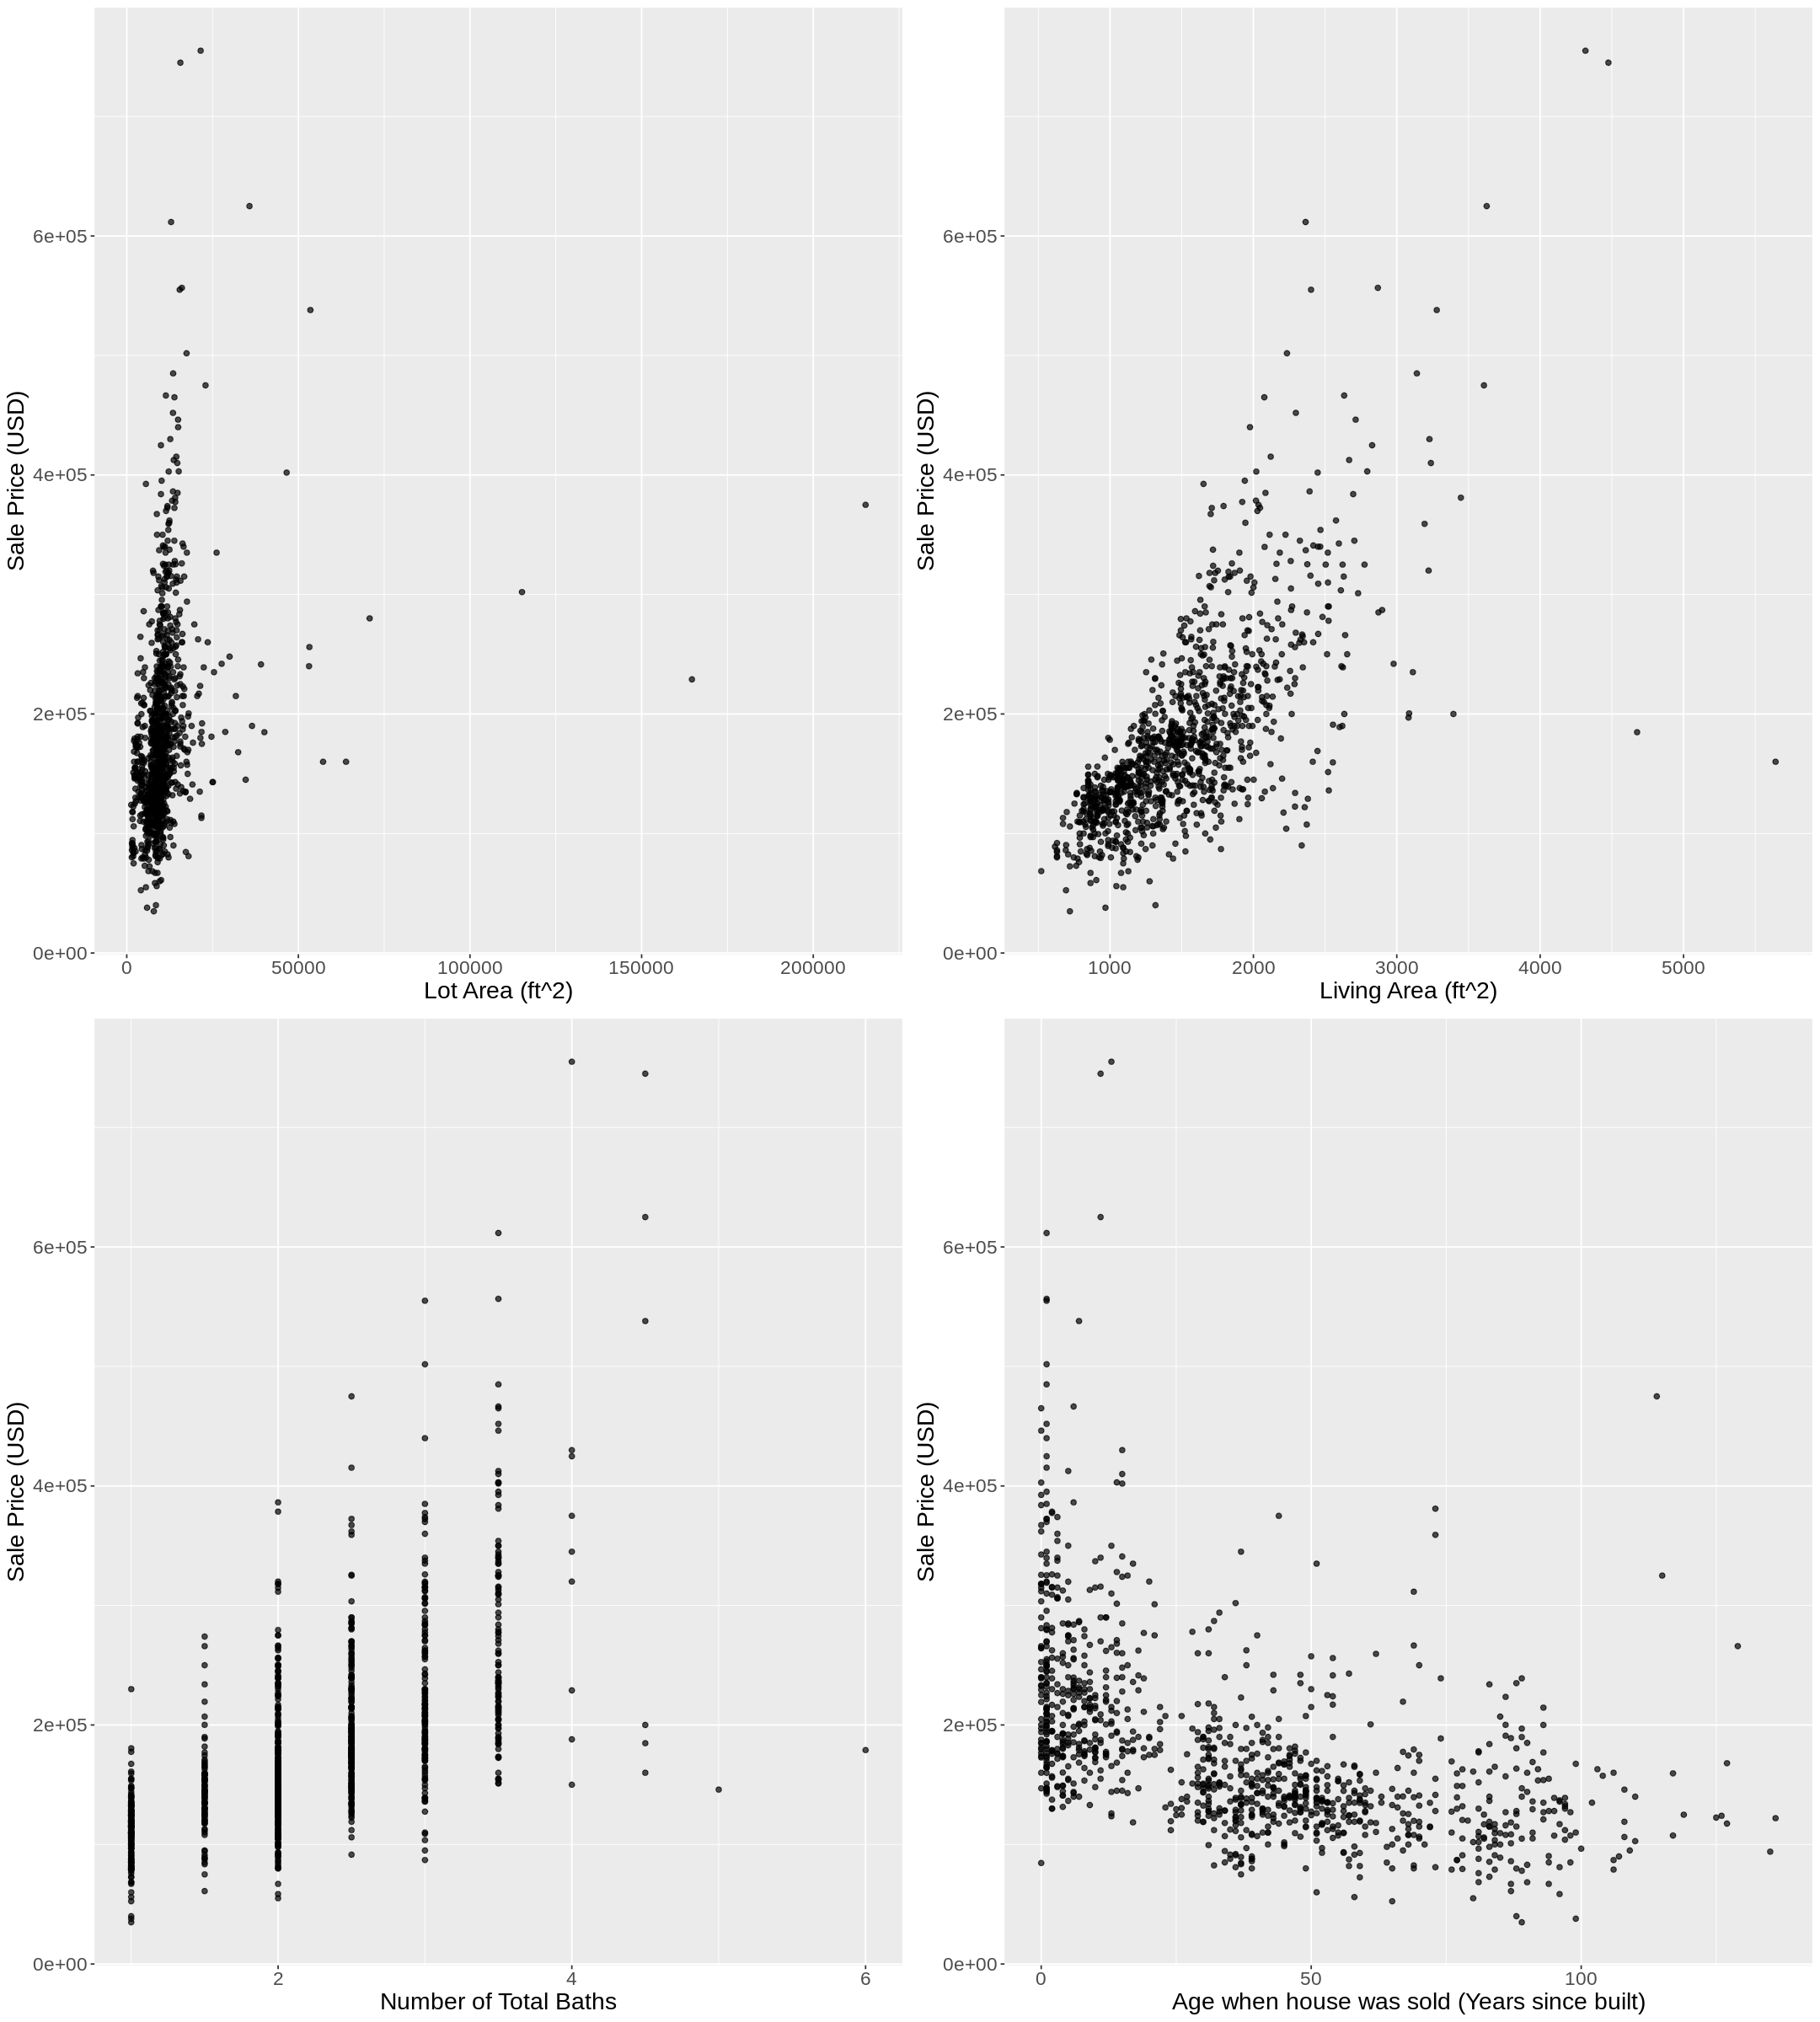

In [31]:
col_names <- c("Lot Area (ft^2)", "Living Area (ft^2)", "Number of Total Baths", "Age when house was sold (Years since built)")

#Remove SalePrice and Id from Numeric data frame
data_without_price <- data_train_final %>%
    select(-SalePrice)

plot_list <- list()

#Plot all Numeric variables against SalePrice and storing them in a list
for (i in 1:length(names(data_without_price))){
    new_data <- cbind(x_var = data_without_price[i],y_var = data_train_final$SalePrice)
    new_data <- rename(new_data, x_var = 1)
    plot <- ggplot(new_data, aes(y=y_var, x=x_var)) +
        geom_point(alpha = 0.7) +
        labs(y = "Sale Price (USD)", x = col_names[i]) + theme(text = element_text(size=17))
    plot_list[[i]] <- plot
}


plot_grid(plotlist = plot_list)



!!! (TO DO) Short discussion on visual analysis

## 3. Discussion

#### 3.1 Summary of findings

Restate RMSPE discussion and add on.

#### 3.2 Results against expectations

RMSPE is high due to the fact that we did not account for location of the house, which was mentioned to be a large factor in artcles. We did not expect house age to have such a large impact on price (1000 dollars per year).

#### 3.3 Potential impact

In our view, there are two notable potential impacts from this work: 
1. Real estate agents could garner a better understanding into the drivers of home selling prices.
2. We can take key valuation insights with us in our personal life for when we one day purchase homes of our own.

#### 3.4 Future questions

Our analysis on factors contributing to the selling price of a home could spark future questions, including:

- How has the weight of each factor that contributes to the selling price changed over time? Is there a pattern to this change?
- Do the factors contributing most to selling prices in Ames, Iowa (our dataset) also work for other regions?
- How good would our model be if we used location as a a predictive factor?

## 4. References

#### 4.1 Relevant Literature Citations

Md Yusof, Aminah & Ismail, Syuhaida. (2012). Multiple Regressions in Analysing House Price Variations. Communications of the IBIMA. 2012. 1-9. 10.5171/2012.383101. 

Zietz, J., Zietz, E. N., & Sirmans, G. S. (2008). Determinants of house prices: A quantile regression approach. Journal of Real Estate Finance and Economics, 37(4), 317-333. doi:http://dx.doi.org.ezproxy.library.ubc.ca/10.1007/s11146-007-9053-7

https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/ 
(fix this last citation)

#### 4.2 Dataset Citation

(!!! TODO). Cite dataset